In [1]:
import numpy as np
import pandas as pd
import pyampute
from pyampute.ampute import MultivariateAmputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import os
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge, LinearRegression

import statsmodels.api as sm

# Function (all together)

In [2]:
def rubins_pooling_rules(m_coefs, m_vars_coefs):
    """Applies Rubin's pooling rules.
    The final weights is defined as the mean of the weights across the imputed
    datasets while the total variance is defined as the combination of the mean
    of the variance of the weights and the variance of the coefficients.
    Parameters
    ----------
    m_coefs : ndarray, shape (n_imputations, n_features)
        The weights of the model fitted on each imputed dataset.
    m_vars_coefs : ndarray, shape (n_imputations, n_features)
        An estimate of the variance of the weights on each imputed dataset.
    Returns
    -------
    mean_coefs : ndarray, shape (n_features,)
        The mean coefficients computed across the imputed datasets.
    total_var_coefs : ndarray, shape (n_features,)
        An estimate of the total variation of the weights across the imputed
        datasets.
    """
    mean_coefs = np.mean(m_coefs, axis=0)
    mean_vars_coefs = np.mean(m_vars_coefs, axis=0)
    vars_coefs = np.var(m_coefs, axis=0, ddof=1)
    total_var_coefs = mean_vars_coefs + (1 + 1 / vars_coefs.shape[0]) * vars_coefs
    return mean_coefs, total_var_coefs


In [3]:
def dataset():
    X_full = np.genfromtxt(os.path.basename('/Desktop/GIT/Imputations/data_ivanovo.csv') , delimiter=';', skip_header=2)
    df = pd.DataFrame(X_full)
    df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
    
    df_cont = df.copy()
    df_cont = df_cont.iloc[:, 6:18]
    df_cont.columns = [str(i) for i in range(df_cont.shape[1])]
    return df_cont

In [4]:
def coefs_vars(df):
    X = sm.add_constant(df.iloc[:, 0:3])
    ols = sm.OLS(df.iloc[:,3], X)
    ols_result = ols.fit()
    
    coefss = ols_result.params
    varss = ols_result.bse #this is SE!
#     conf_int = (ols_result.conf_int(alpha=0.05, cols=None)[1] - ols_result.conf_int(alpha=0.05, cols=None)[0]) / 2
    
    return coefss, varss

In [5]:
def ampute(df, pat):
    pr = prop

    ma = MultivariateAmputation(
            patterns = pat,
            prop = pr
        )
    X_miss = ma.fit_transform(df)  
    return X_miss

In [6]:
def mice(X_miss):
    n_imputations = 10
    imp_mice = []

    for i in range(5):
        imp = IterativeImputer(random_state = i, sample_posterior = True, estimator = BayesianRidge()).fit_transform(X_miss)
        imp = pd.DataFrame(imp)
        imp_mice.append(imp)
        
    
    return imp_mice

In [7]:
def pooling(imp_mice):
    m_coefs = []
    m_vars = []
    
    for imp in imp_mice:
        
        mice_coefs, mice_vars = coefs_vars(pd.DataFrame(imp))

        m_coefs.append(mice_coefs)
        m_vars.append(mice_vars)

    m_coefs = np.array(m_coefs)
    m_vars = np.array(m_vars)
    
    
    mice_means = rubins_pooling_rules(m_coefs, m_vars)[0]
    mice_varis = rubins_pooling_rules(m_coefs, m_vars)[1]
#     mice_conf_int = 2 * mice_varis / np.sqrt(imp_mice.shape[0])
    
    return mice_means, mice_varis

In [30]:
def plott(columns, df_coefs, df_conf_int, CC_coef, CC_conf_int, mice_coef, mice_conf_int):
   
    fig, ax = plt.subplots(1, 1, figsize=(10, 12), sharex=True)
    xs = 5 * np.array(range(4))
    
#     ax.bar(x = xs,  
#            height = df_coefs, 
#            width = 1, 
#            yerr = df_conf_int, 
#            alpha =1,  
#            edgecolor = 'black',
#            capsize = 4)

    ax.errorbar(x = xs, y = df_coefs, yerr = df_conf_int, fmt = 'o', capsize=4)
    ax.errorbar(x = xs + 1, y = CC_coef, yerr = CC_conf_int, fmt = 'o', capsize=4)
    ax.errorbar(x = xs + 2, y = mice_coef, yerr = mice_conf_int, fmt = 'o', capsize=4)    

#     ax.bar(x= xs + 1,  
#            height = CC_coef, 
#            width = 1, 
#            yerr = CC_conf_int, 
#            alpha = 1,  
#            edgecolor = 'black',
#            capsize=4)


#     ax.bar(x = xs + 2,  
#            height = mice_coef, 
#            width = 1, 
#            yerr = mice_conf_int, 
#            alpha = 1,  
#            edgecolor = 'black',
#            capsize=4)
    
    plt.legend(['original', 'complete case', 'mice'])

    
    ax.xaxis.set_minor_locator(plt.NullLocator()) 
 
    plt.xticks(rotation = 90);
    ax.set_xticks(xs.astype(int) + 1, minor = False)
    ax.set_xticklabels(['bias'] + columns[0:3])

#     ax.set_title("df w/ MICE coefficeints of the linear regression and their variances pooled")

In [31]:
def coeff(columns, pat):
    df_cont = dataset()

    df_1 = df_cont[columns]
    df_coefs, df_vars = coefs_vars(df_1)
    #     df_std = np.sqrt(df_1.shape[0]) * df_vars
    df_conf_int = 2 * df_vars  

    X_miss = ampute(df_1, pat)

    df_CC = X_miss.copy()
    df_CC.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
    CC_coef, CC_vars = coefs_vars(df_CC)
    #     CC_std = np.sqrt(df_CC.shape[0]) * CC_vars
    CC_conf_int = 2 * CC_vars 

    imp_mice = mice(X_miss)
    mice_coef, mice_vars = pooling(imp_mice)
    #     mice_std = np.sqrt(imp_mice[0].shape[0]) * mice_vars
    mice_conf_int = 2 * mice_vars 
        
        
    plott(columns, df_coefs, df_conf_int, CC_coef, CC_conf_int, mice_coef, mice_conf_int)
#     return columns, df_coefs, df_conf_int, CC_coef, CC_conf_int, mice_coef, mice_conf_int

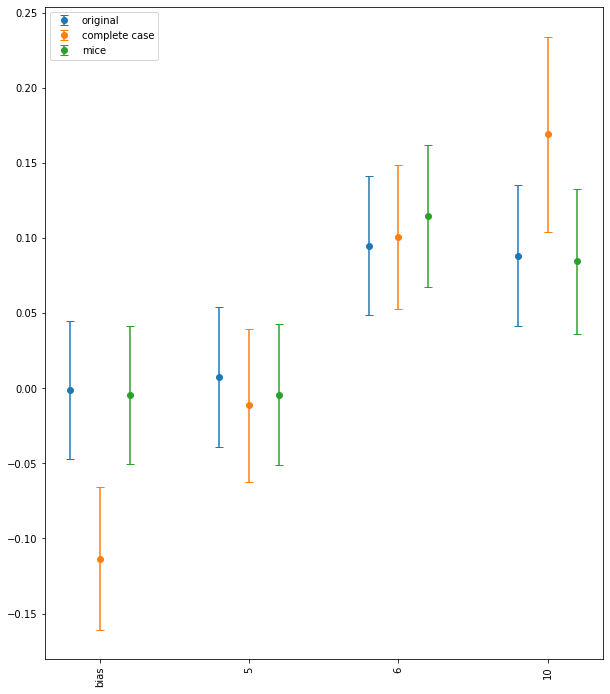

In [32]:
prop = 0.2
coeff(['5','6','10', '11'], pat = [{'incomplete_vars': [0,1], 'mechanism': "MAR"},
                                   {'incomplete_vars': [1,2], 'mechanism': "MAR"}])

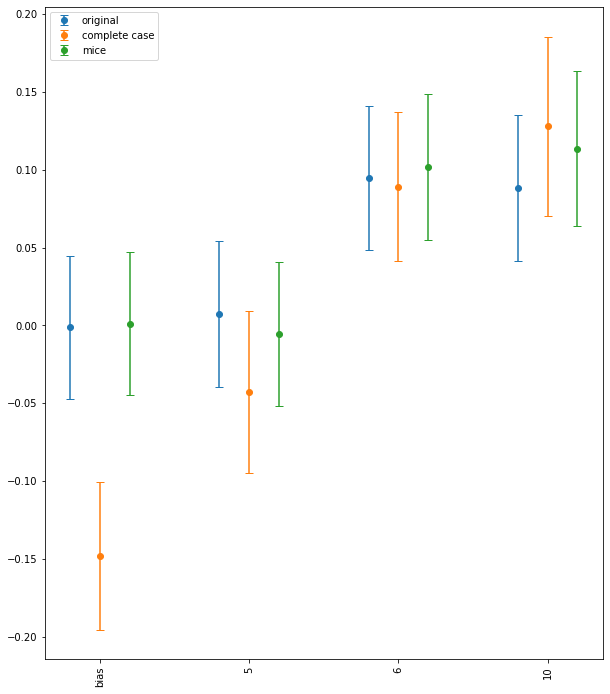

In [33]:
prop = 0.2
coeff(['5','6','10', '11'], pat = [{'incomplete_vars': [0,1], 'mechanism': "MAR"},
                                   {'incomplete_vars': [1,2], 'mechanism': "MAR"}])

# ['5','6','10', '11']

## MAR [0,1]; [1,2]

### pr = 0.2

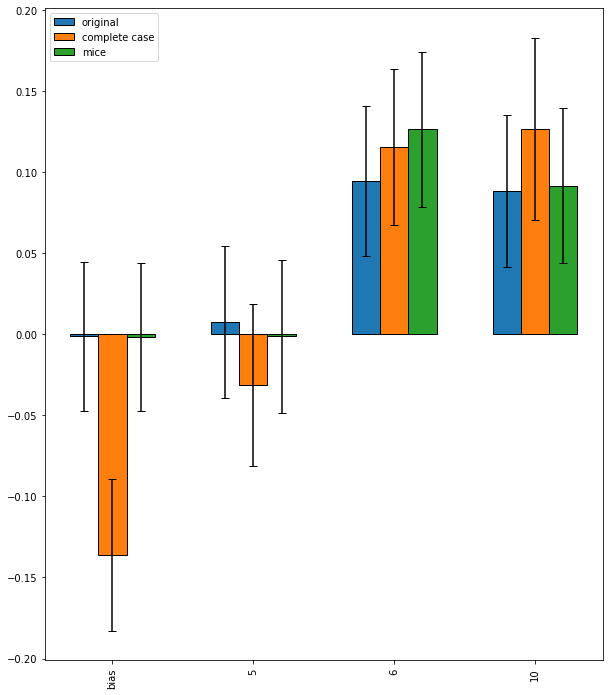

In [11]:
prop = 0.2
coeff(['5','6','10', '11'], pat = [{'incomplete_vars': [0,1], 'mechanism': "MAR"},
                                   {'incomplete_vars': [1,2], 'mechanism': "MAR"}])

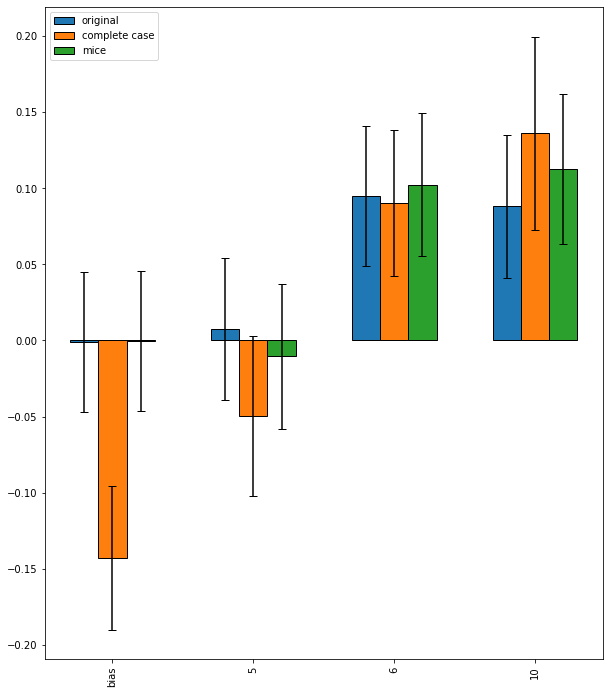

In [13]:
prop = 0.2
coeff(['5','6','10', '11'], pat = [{'incomplete_vars': [0,1], 'mechanism': "MAR"},
                                   {'incomplete_vars': [1,2], 'mechanism': "MAR"}])

### pr = 0.4

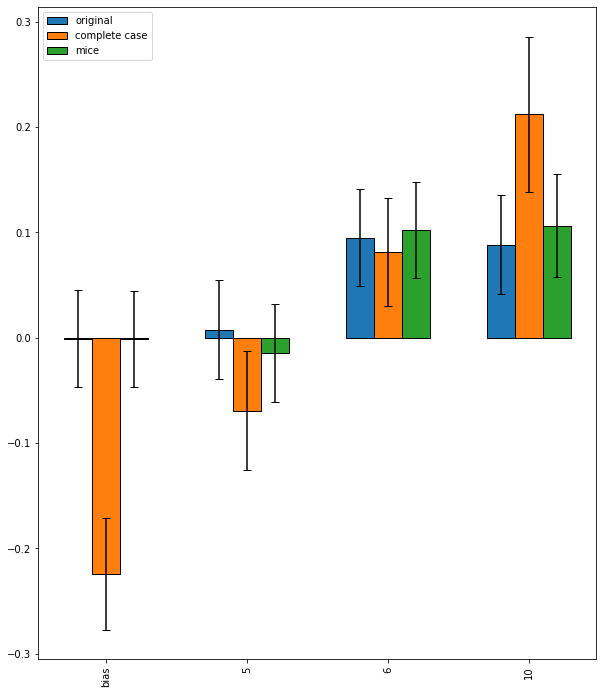

In [16]:
prop = 0.4
coeff(['5','6','10', '11'], pat = [{'incomplete_vars': [0,1], 'mechanism': "MAR"},
                                   {'incomplete_vars': [1,2], 'mechanism': "MAR"}])

## MAR [0], MAR [1, 2], MNAR [0,2]

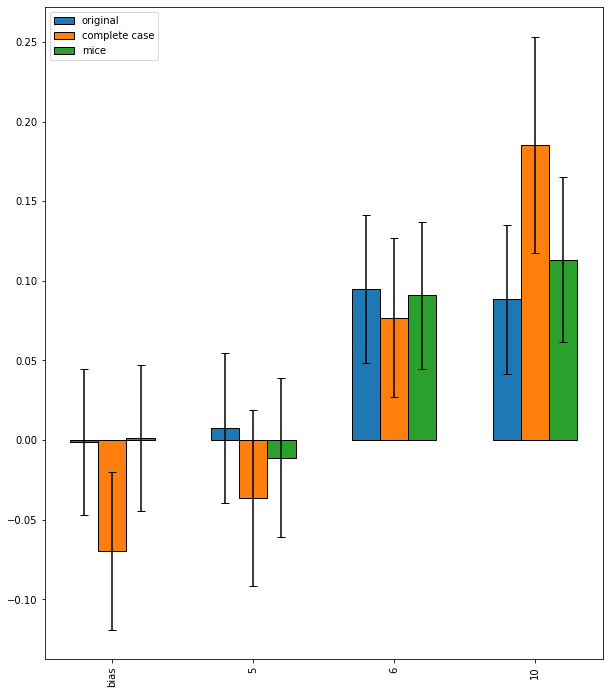

In [15]:
prop = 0.2
coeff(['5','6','10', '11'], pat = [{'incomplete_vars': [0], 'mechanism': "MAR"},
                                   {'incomplete_vars': [1,2], 'mechanism': "MAR"},
                                   {'incomplete_vars': [0,2], 'mechanism': "MNAR"}])

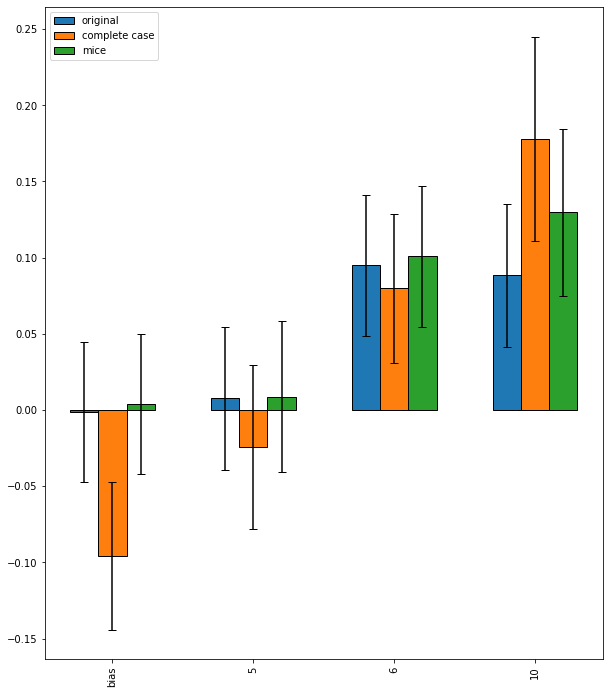

In [17]:
prop = 0.2
coeff(['5','6','10', '11'], pat = [{'incomplete_vars': [0], 'mechanism': "MAR"},
                                   {'incomplete_vars': [1,2], 'mechanism': "MAR"},
                                   {'incomplete_vars': [0,2], 'mechanism': "MNAR"}])

# ['0','6','11', '5']

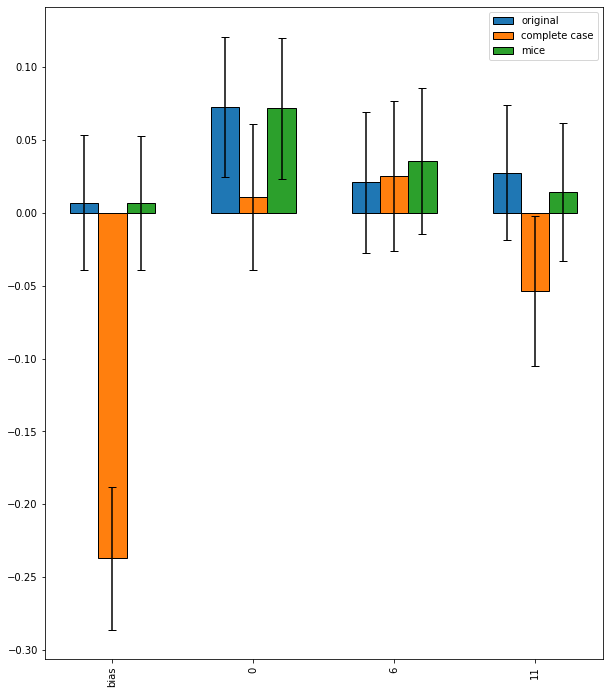

In [18]:
prop = 0.4
coeff(['0','6','11', '5'], pat = [{'incomplete_vars': [0,1], 'mechanism': "MAR"},
                                   {'incomplete_vars': [1,2], 'mechanism': "MAR"}])

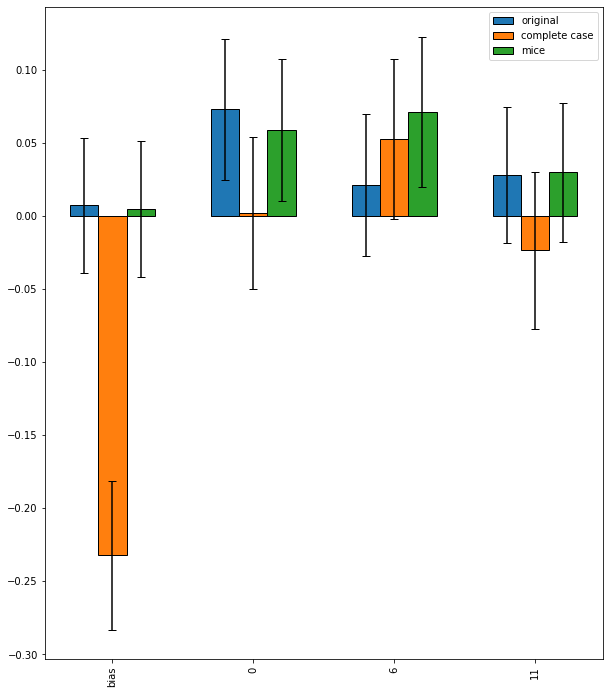

In [19]:
prop = 0.4
coeff(['0','6','11', '5'], pat = [{'incomplete_vars': [0,1], 'mechanism': "MAR"},
                                   {'incomplete_vars': [1,2], 'mechanism': "MAR"}])

# ['4','5','6', '7'], mice_m = 10

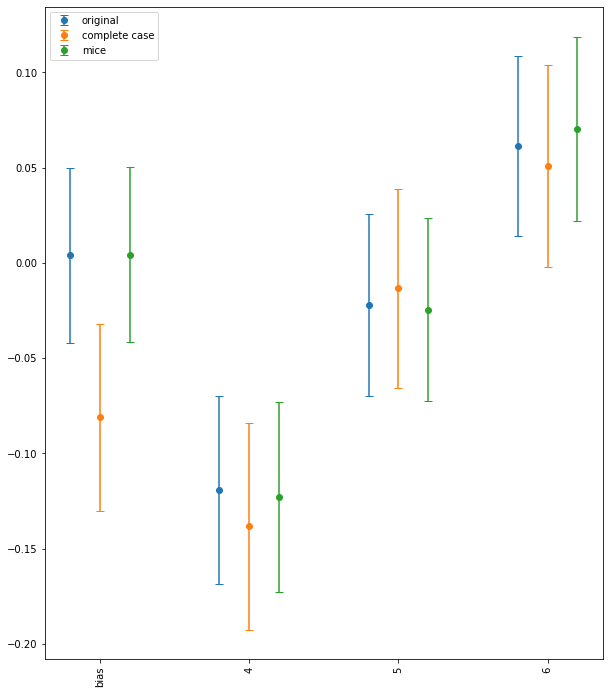

In [34]:
prop = 0.2
coeff(['4','5','6', '7'], pat = [{'incomplete_vars': [0], 'mechanism': "MAR"},
                                   {'incomplete_vars': [1,2], 'mechanism': "MAR"},
                                   {'incomplete_vars': [0,2], 'mechanism': "MNAR"}])

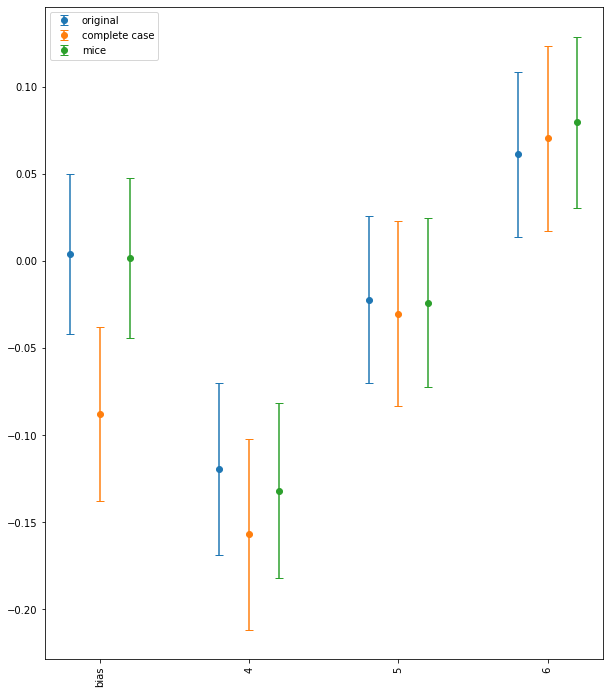

In [35]:
prop = 0.2
coeff(['4','5','6', '7'], pat = [{'incomplete_vars': [0], 'mechanism': "MAR"},
                                   {'incomplete_vars': [1,2], 'mechanism': "MAR"},
                                   {'incomplete_vars': [0,2], 'mechanism': "MNAR"}])

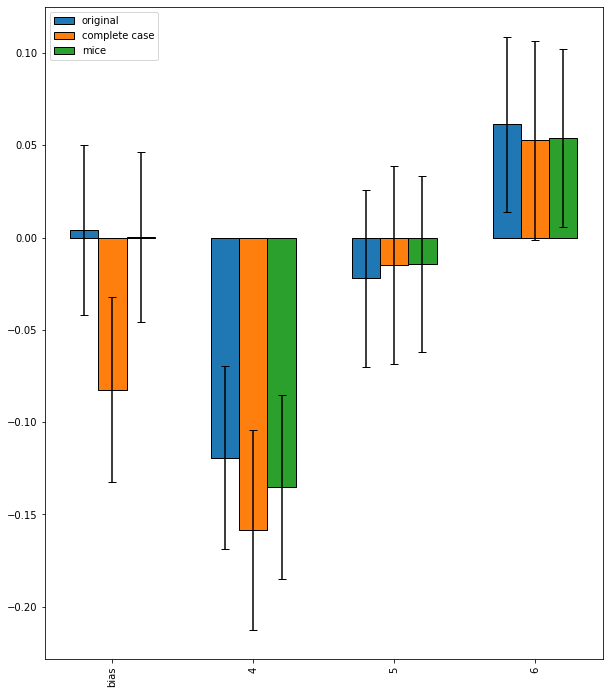

In [21]:
prop = 0.2
coeff(['4','5','6', '7'], pat = [{'incomplete_vars': [0], 'mechanism': "MAR"},
                                   {'incomplete_vars': [1,2], 'mechanism': "MAR"},
                                   {'incomplete_vars': [0,2], 'mechanism': "MNAR"}])

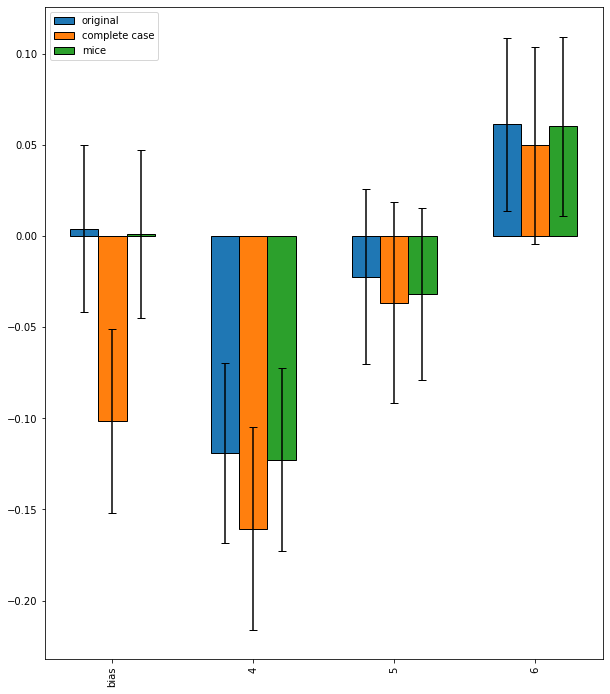

In [24]:
prop = 0.2
coeff(['4','5','6', '7'], pat = [{'incomplete_vars': [0], 'mechanism': "MAR"},
                                   {'incomplete_vars': [1,2], 'mechanism': "MAR"},
                                   {'incomplete_vars': [0,2], 'mechanism': "MNAR"}])